<a href="https://colab.research.google.com/github/ciastirfry/Quantum_Computing/blob/main/Quantum_ML_Task4_AerSimulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Quantum Computing (Lab 10 — Quantum ML)**

### Author’s Name : Fredierick Saladas
### Student ID : 270609973@yoobeestudent.ac.nz
### College : Yoobee College of Creative Innovation
### Course : MSE802 Quantum Computing
### Supervisor : Dr. Arun Kumar
#### Date : 15 November 2025

In this lab you will create some quantum machine learning models and run them on the Quokka.

# Task 4 – Machine Learning Quantum Analysis (LO1, 2, 4)

This section of the notebook implements the requirements of Task 4 from the assessment brief.

• **Executing the code and monitoring the final output at each iteration** – the objective function has been modified so that each call records both the current value of the cost (output measure) and the time taken to compute it.
• **Plotting iteration number against the output measure** – additional code collects the logged values for each optimiser (Nelder–Mead and SPSA) and produces a graph of iteration index versus objective value.
• **Plotting iteration number against the time required for producing the output** – a second graph is produced from the logged timing data, showing iteration index versus wall‑clock time taken per objective evaluation.

These plots are generated automatically in the *Visualisation of optimisation performance* cell after both optimisers have been run for the selected backend (`BACKEND_MODE`).

In [1]:
!pip install qiskit qiskit-aer


In [2]:
# the usual imports
import numpy as np
import scipy as sp
import requests
import math
import json
import sympy

from google.colab import files

# current Quokka address:
req_str_qasm = 'http://quokka1.quokkacomputing.com/qsim/qasm'

# --- Task 4 additions: timing, logging, and backend helpers ---
import time

# Backend mode: use "quokka" for the QA device, or "aer" for local AerSimulator
BACKEND_MODE = "aer"  # default: use local Qiskit AerSimulator; set to "quokka" to use QA device

# History containers for optimisation traces
history = {
    "quokka": {
        "nelder-mead": {"values": [], "times": []},
        "spsa": {"values": [], "times": []},
    },
    "aer": {
        "nelder-mead": {"values": [], "times": []},
        "spsa": {"values": [], "times": []},
    },
}

def reset_history(backend_mode=None):
    """Clear the logged optimisation history for a given backend.

    If backend_mode is None, the currently selected BACKEND_MODE is used.
    """
    global history, BACKEND_MODE
    if backend_mode is None:
        backend_mode = BACKEND_MODE
    for opt in history[backend_mode]:
        history[backend_mode][opt]["values"].clear()
        history[backend_mode][opt]["times"].clear()


def run_qasm_circuit(qasm, count=100, backend_mode=None):
    """Execute a QASM circuit on Quokka or on a local AerSimulator.

    Returns a NumPy array of single-bit measurement outcomes (0/1).
    """
    if backend_mode is None:
        backend_mode = BACKEND_MODE

    if backend_mode == "quokka":
        data = {"count": int(count), "script": qasm}
        result = requests.post(req_str_qasm, json=data)
        json_obj = json.loads(result.content)
        res = json_obj["result"]
        # Quokka may return either a list of shots ('c') or a pre-averaged result.
        if "c" in res:
            return np.array(res["c"], dtype=float)
        else:
            mean_val = float(res["result"])
            return np.full(int(count), mean_val, dtype=float)

    elif backend_mode == "aer":
        # Local simulation using Qiskit Aer (ensure qiskit & qiskit-aer are installed)
        from qiskit import QuantumCircuit
        from qiskit_aer import AerSimulator

        qc = QuantumCircuit.from_qasm_str(qasm)
        backend = AerSimulator()
        job = backend.run(qc, shots=int(count))
        result = job.result()
        counts = result.get_counts()
        zeros = counts.get("0", 0)
        ones = counts.get("1", 0)
        return np.array([0] * zeros + [1] * ones, dtype=float)

    else:
        raise ValueError(f"Unknown backend_mode: {backend_mode}")

In [3]:
# Optional: install Qiskit and Qiskit Aer when running on a fresh Colab runtime
# Uncomment the next line if AerSimulator is not available.
# !pip install qiskit qiskit-aer


# Hello, Quantum learner!

Let's start by teaching a quantum circuit to output the number 1. Thrilling!

Below is a function that creates a circuit with a single rotation parameter and then measures.

In [4]:
def qubit_learner(angle, count = 1000):
  qasm = '''
  OPENQASM 2.0;
  include "qelib1.inc";
  qreg q[1];
  creg result[1];
  rx({}) q[0];
  measure q[0] -> result[0];
  '''.format(angle[0])

  data = {'count': count,
          'script': qasm
          }

  result = requests.post(req_str_qasm, json=data)
  json_obj = json.loads(result.content)
  return np.mean(json_obj['result']['result'])

def objective_function(angle, bit = 1):
  error = bit - qubit_learner(angle)
  return np.abs(error)**2

We will use a built-in Scipy optimizer to demonstrate the model. Remember, each time the function is called, the Quokka runs a new circuit some number of times and returns the results.

In [5]:
sp.optimize.minimize(objective_function,
                     x0 = np.random.randn(),
                     method = 'Nelder-Mead',
                     options ={'maxiter':10})

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 0.0
             x: [-3.102e+00]
           nit: 10
          nfev: 27
 final_simplex: (array([[-3.102e+00],
                       [-3.103e+00]]), array([ 0.000e+00,  0.000e+00]))

## Quantum image classification

Let's do something a bit more substantial. Here we will train a quantum model to distinguish bars versus stripes in an image. First, we create the dataset.  

In [6]:
def generate_binary_code(bit_length):
    bit_combinations = np.zeros((int(2**bit_length), bit_length))
    for number in range(int(2**bit_length)):
        dividend = number
        bit_index = 0
        while dividend != 0:
            bit_combinations[number, bit_index] = np.remainder(dividend, 2)
            dividend = np.floor_divide(dividend, 2)
            bit_index += 1
    return bit_combinations

def generate_data(length):
    stripes = generate_binary_code(length)
    stripes = np.repeat(stripes, length, 0)
    stripes = stripes.reshape(2 ** length, length * length)

    bars = generate_binary_code(length)
    bars = bars.reshape(2 ** length * length, 1)
    bars = np.repeat(bars, length, 1)
    bars = bars.reshape(2 ** length, length * length)

    return np.vstack((stripes[1:stripes.shape[0]-1],bars[1:bars.shape[0]-1]))

The only parameter is the size of the image. (Note that the number of qubits used is the number of pixels, so don't go overboard. More than four pixels will take a lot of time to simulate.)

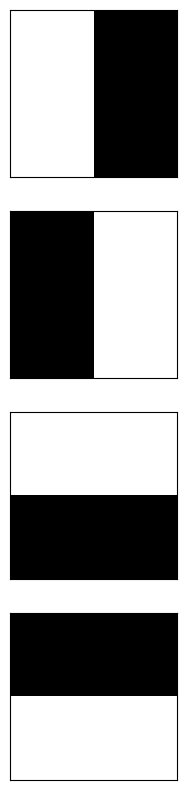

In [7]:
length = 2
dataset = generate_data(length)
labels = np.concatenate((np.zeros(int(2**length-2)),np.ones(int(2**length-2))))
n_parameters = int(2*(length**2-1))

import matplotlib.pyplot as plt

plt.figure(figsize=[10, 10])
j = 1
for i in dataset:
    plt.subplot(4, int(2**(length-1)-1), j)
    j += 1
    plt.imshow(np.reshape(i, [length,length]), cmap="gray")
    plt.xticks([])
    plt.yticks([])

In [8]:
# Select 75% of the entries in the array
selected_indices = np.random.choice(dataset.shape[0],
                                    int(dataset.shape[0] * 0.75),
                                    replace=False)

all_indices = np.arange(dataset.shape[0])
unselected_indices = np.setdiff1d(all_indices, selected_indices)

# Get the selected elements
training = dataset[selected_indices]
training_labels = labels[selected_indices]
test = dataset[unselected_indices]
test_labels = labels[unselected_indices]

## Creating the model

We will create a model built recursively of blocks that entangle pairs of qubits.

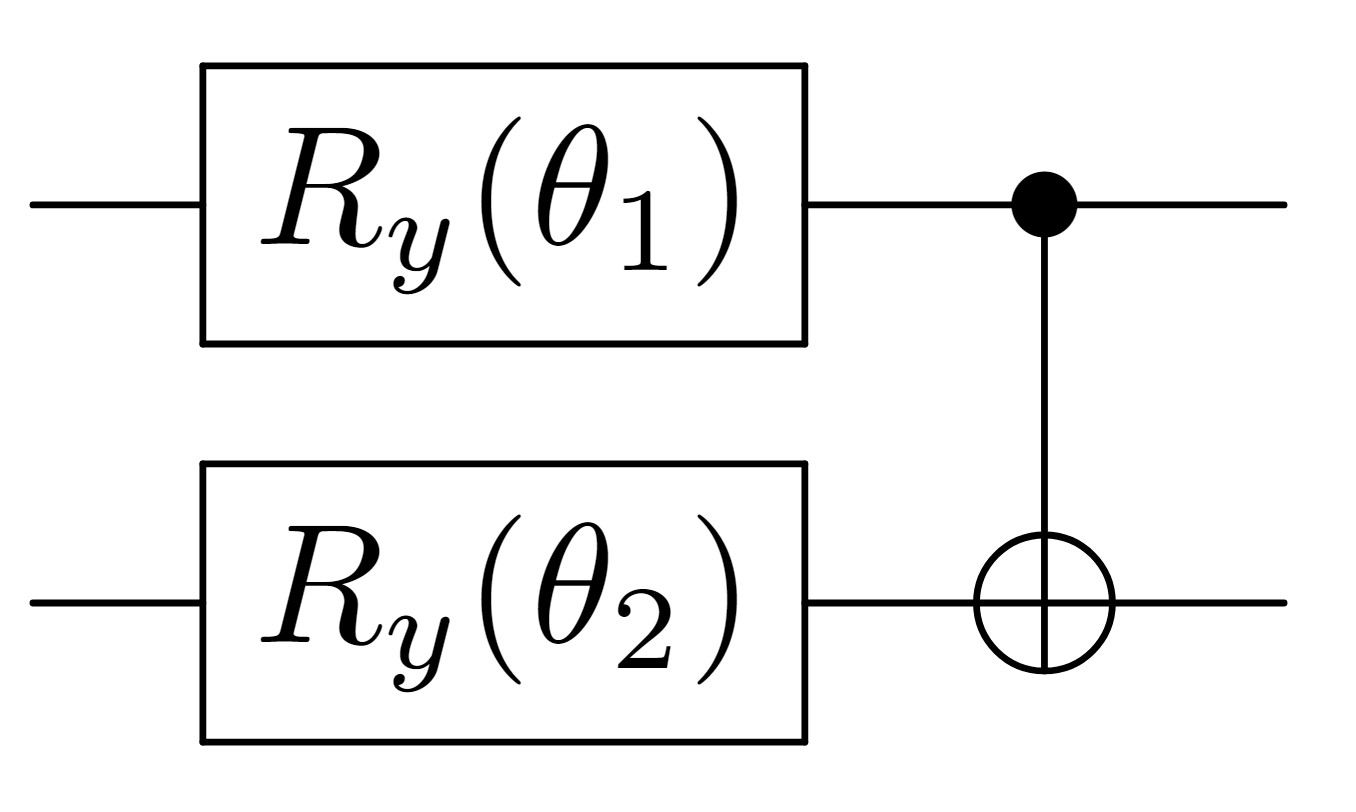

In [9]:
def block(angles,qubits):
  qasm = '''
  ry({}) q[{}];
  ry({}) q[{}];
  cx q[{}], q[{}];
  '''.format(
      angles[0],qubits[0],
      angles[1],qubits[1],
      qubits[0],qubits[1]
  )
  return qasm

Now you will put the blocks together recursively by spliting the circuit in half successively, creating a logarithmic depth circuit. The four qubit case should look like this.

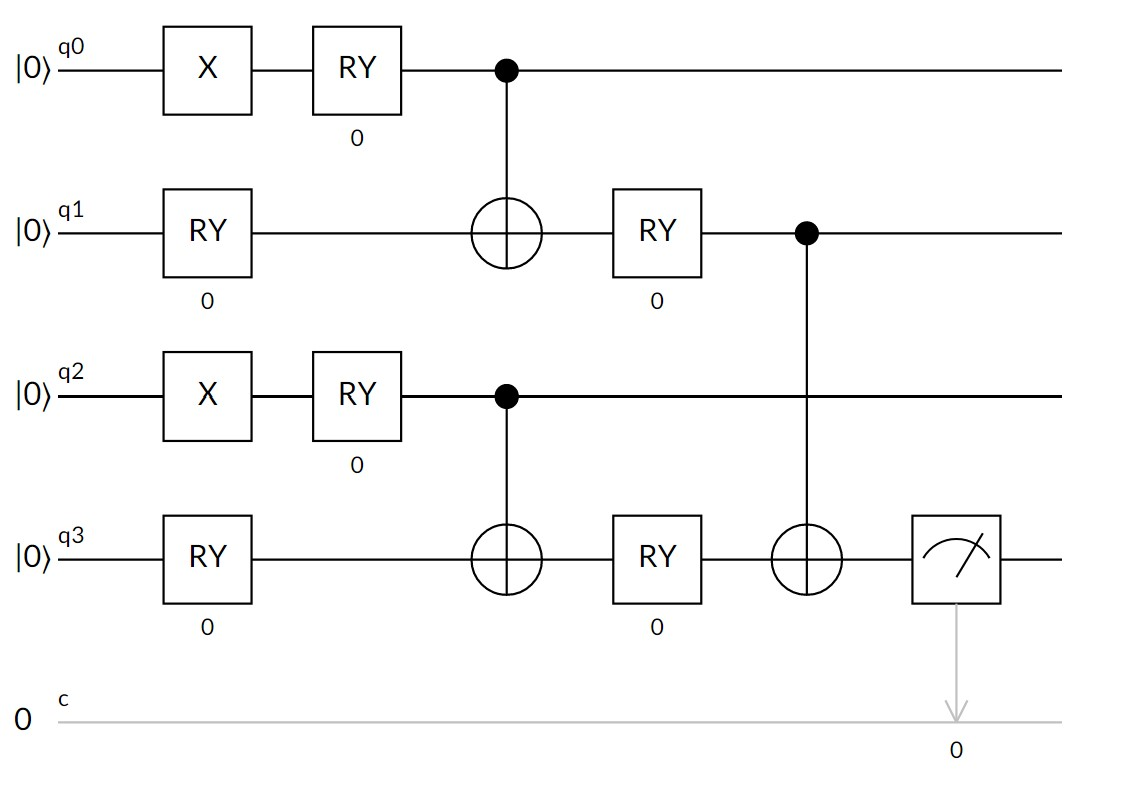

A helper function can generate all the pairs of qubits needed.

In [10]:
def generate_pairs(mylist, start, end):
  if start == end:
      pass
  else:
    mid = (start + end - 1) // 2
    first_half = generate_pairs(mylist, start, mid)
    second_half = generate_pairs(mylist, mid + 1, end)
    mylist.append((mid,end))

In [11]:
def create_circuit(data,angles):

  length = data.shape[0]

  qasm = '''
    OPENQASM 2.0;
    include "qelib1.inc";
    qreg q[{}];
    creg c[1];
    '''.format(length)

  for i in range(length):
    if data[i] > 0.5:
      qasm += '''
    x q[{}];
    '''.format(i)

  pairs = []
  generate_pairs(pairs,0,length-1)

  count = 0
  for (i,j) in pairs:
    qasm += block([angles[count],angles[count+1]],[i,j])
    count += 2

  qasm += '''
  measure q[{}] -> c[0];
  '''.format(length-1)

  return(qasm)

In [12]:
# Check out an example with all zero angles.

print(create_circuit(dataset[0],np.zeros(n_parameters)))


    OPENQASM 2.0;
    include "qelib1.inc";
    qreg q[4];
    creg c[1];
    
    x q[0];
    
    x q[2];
    
  ry(0.0) q[0];
  ry(0.0) q[1];
  cx q[0], q[1];
  
  ry(0.0) q[2];
  ry(0.0) q[3];
  cx q[2], q[3];
  
  ry(0.0) q[1];
  ry(0.0) q[3];
  cx q[1], q[3];
  
  measure q[3] -> c[0];
  


## Learning!

Here you will create your objective function, which calls the Quokka, and run the classical optimizer. We'll use the same one as above for simplicity and then build our own below.

In [13]:
def objective(x, dataset, labels, count = 10, optimizer_name=None):
  """Objective (cost) function for the image-classification task.

  Args:
      x: Current parameter vector for the variational circuit.
      dataset: Array of input images (each flattened into a 1D vector).
      labels: Binary labels (0 for bars, 1 for stripes).
      count: Number of measurement shots used per circuit execution.
      optimizer_name: Optional string identifying the optimiser calling this
                      function (e.g. "nelder-mead" or "spsa") so that we can
                      log per-iteration values and timing.

  Returns:
      Average absolute error between measured expectation value and label.
  """

  n_data = dataset.shape[0]
  to_return = 0.0

  start_time = time.time()

  for idx in range(n_data):

    # Build the data-encoding variational circuit for this training example
    qasm = create_circuit(dataset[idx], x)

    # Run either on Quokka QA device or on local AerSimulator
    values = run_qasm_circuit(qasm, count=count, backend_mode=BACKEND_MODE)

    # The model predicts the mean of the sampled bit values; we compare to label
    to_return += np.abs(
        np.mean(values) - labels[idx]
    )

  value = to_return / n_data
  elapsed = time.time() - start_time

  # Log value and timing for this optimisation step (if requested)
  if optimizer_name is not None:
    backend = BACKEND_MODE
    if backend in history and optimizer_name in history[backend]:
      history[backend][optimizer_name]["values"].append(value)
      history[backend][optimizer_name]["times"].append(elapsed)

  return value


In [14]:
# Task 4: Nelder–Mead optimisation with logging
# Choose backend: "quokka" (QA device) or "aer" (local AerSimulator)
# BACKEND_MODE = "quokka"   # uncomment to use Quokka
# BACKEND_MODE = "aer"      # uncomment to use local Aer simulator

# Clear any previous optimisation history for the selected backend
reset_history()

nelder_mead_result = sp.optimize.minimize(
    lambda x: objective(x, training, training_labels, count=int(1e2), optimizer_name="nelder-mead"),
    x0=np.pi * np.random.randn(n_parameters),
    method="Nelder-Mead",
    options={"maxiter": int(1e1)},
)
print("Nelder–Mead optimisation finished.")
print("Backend:", BACKEND_MODE)
print("Logged Nelder–Mead iterations:", len(history[BACKEND_MODE]["nelder-mead"]["values"]))
if history[BACKEND_MODE]["nelder-mead"]["values"]:
    print("Final Nelder–Mead objective value:", history[BACKEND_MODE]["nelder-mead"]["values"][-1])


Nelder–Mead optimisation finished.
Backend: aer
Logged Nelder–Mead iterations: 18
Final Nelder–Mead objective value: 0.3666666666666667


## A different optimizer

The [Simultaneous Perturbation Stochastic Approximation](https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation) (SPSA) algorithm is a popular stochastic optimization technique for solving optimization problems in a variety of applications. It was first introduced by Spall in 1992 as a variant of the stochastic approximation method.

SPSA is a gradient-free optimization algorithm, meaning that it does not require knowledge of the gradient of the objective function. Instead, it uses a series of random perturbations to estimate the gradient of the objective function at each iteration. This makes it well-suited for optimizing functions that are expensive or difficult to compute gradients for.

At each iteration, the SPSA algorithm randomly perturbs the input variables and computes the corresponding function values. It then uses these function values to estimate the gradient of the objective function, and updates the input variables using a stochastic approximation rule. This process is repeated until convergence is achieved or a stopping criterion is met.

One of the key advantages of SPSA is its simplicity and ease of implementation.

In [15]:
def spsa(func, x0, log_func=None, a=0.1, c=0.01, alpha=0.602, gamma=0.101, maxiter=100, verbose=False):
    """Simultaneous Perturbation Stochastic Approximation (SPSA).

    Args:
        func: Function used to evaluate the objective for gradient approximation.
        x0: Initial parameter vector.
        log_func: Optional function used once per iteration to log objective
                  values (e.g. wraps `objective` with optimizer_name="spsa").
        a, c, alpha, gamma: SPSA hyper-parameters.
        maxiter: Number of iterations.
        verbose: If True, print progress every ~10% of iterations.
    """

    k = 0
    x = x0

    while k < maxiter:
        ak = a / (k + 1) ** alpha
        ck = c / (k + 1) ** gamma
        delta = 2 * np.random.randint(0, 2, len(x0)) - 1
        xp = x + ck * delta
        xm = x - ck * delta
        grad = (func(xp) - func(xm)) / (2 * ck) * delta

        x = x - ak * grad

        if log_func is not None:
            fx = log_func(x)
        elif verbose and k % max(1, int(0.1 * maxiter)) == 0:
            fx = func(x)
            print(f"Iteration {k}: f = {fx}")

        k += 1

    return x


In [16]:
# Task 4: SPSA optimisation with logging on the selected backend

# Define two wrappers: one for gradient estimation, one for logging per iteration
def spsa_func(x):
    return objective(x, training, training_labels, count=int(1e2))

def spsa_log_func(x):
    return objective(x, training, training_labels, count=int(1e2), optimizer_name="spsa")

f = spsa_func
x0 = np.pi * np.random.randn(n_parameters)

a = 1
c = 0.5
maxiter = int(1e2)
alpha = 0.602
gamma = 0.101

xsol = spsa(
    f,
    x0,
    log_func=spsa_log_func,
    a=a,
    c=c,
    alpha=alpha,
    gamma=gamma,
    maxiter=maxiter,
    verbose=True,
)

print("SPSA optimisation finished.")
print("Backend:", BACKEND_MODE)
print("Logged SPSA iterations:", len(history[BACKEND_MODE]["spsa"]["values"]))
if history[BACKEND_MODE]["spsa"]["values"]:
    print("Final SPSA objective value:", history[BACKEND_MODE]["spsa"]["values"][-1])


SPSA optimisation finished.
Backend: aer
Logged SPSA iterations: 100
Final SPSA objective value: 0.0


Generating Task 4 plots for backend: aer


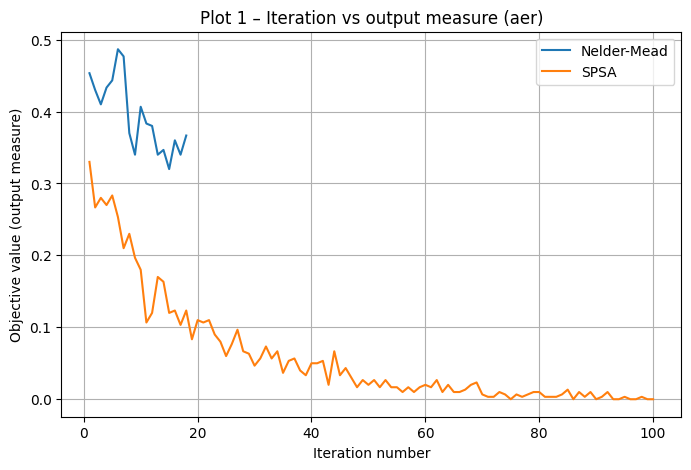

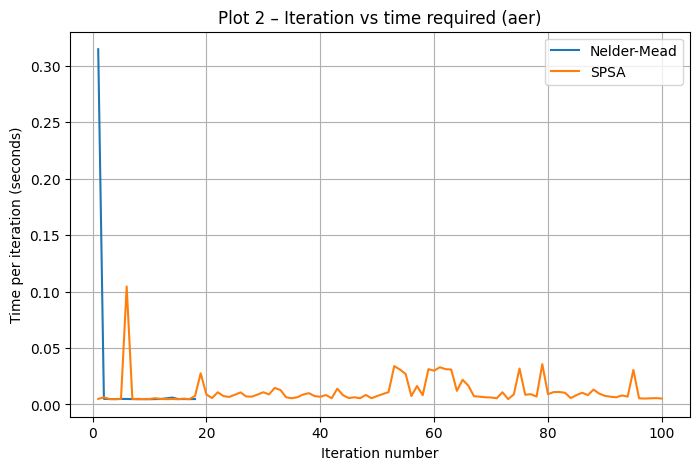

In [17]:
# Task 4: Visualisation of optimisation performance
# This cell creates the graphs required by the brief:
#  1. Iteration number vs output measure (objective value)
#  2. Iteration number vs time required for producing the output

import matplotlib.pyplot as plt

def plot_value_vs_iteration(backend_mode):
    """Plot objective value vs iteration for both optimisers on a given backend."""
    nm_vals = history[backend_mode]["nelder-mead"]["values"]
    spsa_vals = history[backend_mode]["spsa"]["values"]

    plt.figure(figsize=(8, 5))
    if len(nm_vals) > 0:
        plt.plot(range(1, len(nm_vals) + 1), nm_vals, label="Nelder-Mead")
    if len(spsa_vals) > 0:
        plt.plot(range(1, len(spsa_vals) + 1), spsa_vals, label="SPSA")
    plt.xlabel("Iteration number")
    plt.ylabel("Objective value (output measure)")
    plt.title(f"Plot 1 – Iteration vs output measure ({backend_mode})")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_time_vs_iteration(backend_mode):
    """Plot time per iteration (objective call) for both optimisers."""
    nm_times = history[backend_mode]["nelder-mead"]["times"]
    spsa_times = history[backend_mode]["spsa"]["times"]

    plt.figure(figsize=(8, 5))
    if len(nm_times) > 0:
        plt.plot(range(1, len(nm_times) + 1), nm_times, label="Nelder-Mead")
    if len(spsa_times) > 0:
        plt.plot(range(1, len(spsa_times) + 1), spsa_times, label="SPSA")
    plt.xlabel("Iteration number")
    plt.ylabel("Time per iteration (seconds)")
    plt.title(f"Plot 2 – Iteration vs time required ({backend_mode})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Automatically generate both plots for the backend used in this run
print(f"Generating Task 4 plots for backend: {BACKEND_MODE}")
plot_value_vs_iteration(BACKEND_MODE)
plot_time_vs_iteration(BACKEND_MODE)
